# Classification using artificial neural networks (ANN)s

In [1]:
import numpy as np
import torch.nn as nn
from torch import optim
from torch.nn.modules import Module
import torch.nn.functional as F
from collections import Counter
import pandas as pd
import torch
import random
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [2]:
# file names 
file_names = ['KKL366_220124_deconvolved', 'KKL366_220124_dff-denoised', 
              'KKL366_220125_deconvolved','KKL366_220125_dff-denoised',
              'KKL366_220126_deconvolved', 'KKL366_220126_dff-denoised'
             ]

os.chdir('/home/priya/Desktop/CompSci/compsci-project-2/src/data')

# Simple Neural network

In [3]:
def model_def(n_in, n_h, n_out):
    if not isinstance(n_h, list):
        model = nn.Sequential(nn.Linear(n_in, n_h),
                         nn.ReLU(),
                         nn.Dropout(p=0.5),
                         nn.Linear(n_h, n_out))
    elif isinstance(n_h, list):
        model = nn.ModuleList()
        for h in n_h :
            model.append(nn.Linear(n_in, h))
            model.append(nn.ReLU())
        model.append(nn.Dropout(p=0.5))
        model.append(nn.Linear(h, n_out))
    return model

# training routine, backprop
def training(trainloader, valloader, model, epochs, criterion, optimizer, folder):
    min_val_loss = np.inf
    for e in range(epochs):
        return_epoch = epochs
        filename = os.path.join(folder, 'epoch_'+str(e+1)+'.pth')
        train_loss = 0.0
        val_loss = 0.0
        train_acc= 0 
        for data, labels in trainloader:
            output = model(data.float())
            #compute accuracy
            train_acc += (torch.argmax(output, axis=-1)==labels).sum().item()/labels.size(0)
                        
            # Training pass
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
#         print('Epoch'+str(e+1)+':',f"Training loss: {train_loss/len(trainloader)}", f"Training accuracy: {train_acc/len(trainloader)}" ) 
        
        model.eval()
        for data_v, labels_v in valloader:
            # Calculate Validation Loss
            output_v = model(data_v.float())        
            loss_v = criterion(output_v, labels_v)
            val_loss += loss_v.item()
#         print('Epoch'+str(e+1)+':',f"Validation loss: {val_loss/len(valloader)}")

        if min_val_loss > val_loss:
#             print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f})')
            min_val_loss = val_loss
            return_epoch = e+1
        # Saving State Dict
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss}, filename)
            
    return model, return_epoch

# Data preparation

In [4]:
def downsample(data, labels, n_samples = 162):
    # convert each sample to one day array by choosing the max value for all cells
    df = pd.DataFrame(data = np.max(data, axis=-1))
    df = df.assign(labels = labels)
    df_downsample = df.groupby('labels').apply(lambda x: x.sample(n_samples))
    
    #convert to numpy arrays
    labels_ds = df_downsample['labels']
    del(df_downsample['labels'])
    le = LabelEncoder()
    labels_ds = le.fit_transform(labels_ds)
    
    #convert to numpy array
    data_ds = df_downsample.to_numpy()
    return data_ds, labels_ds, list(le.classes_)
  

def z_normalize(data_train, data_val, data_test):
    # only normalize the data columns
    scaler = StandardScaler()
    data_train_n= scaler.fit_transform(data_train)
    data_val_n = scaler.transform(data_val)
    data_test_n = scaler.transform(data_test)
    return data_train_n, data_val_n, data_test_n


class TPDataset(Dataset):

    def __init__(self, data, labels, train_ids, test_ids, phase= 0):
        # split into train and test
        X_train, X_test, y_train, y_test = data[train_ids], data[test_ids], labels[train_ids], labels[test_ids]
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle= True, stratify = y_train) # 0.25 x 0.8 = 0.2
        #normalize the train data and also test data
        X_train_n , X_val_n, X_test_n = z_normalize(X_train, X_val, X_test)
        # three modes - train, val and test
        if phase == 0:
            self.x_data, self.y_data = X_train_n, y_train
        elif phase == 1:
            self.x_data, self.y_data = X_val_n, y_val
        elif phase== 2:
            self.x_data, self.y_data = X_test_n, y_test
            
    def __len__(self):
        return self.y_data.shape[0]
    
    def __getitem__(self, i):
        return self.x_data[i], int(self.y_data[i])

## 1 hidden Layer network

 
 Mean Test accuracy across folds for KKL366_220124_deconvolved: 98.6111111111111


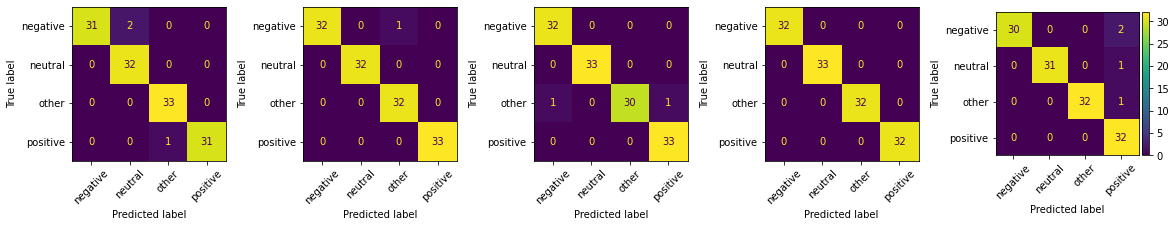

 
 Mean Test accuracy across folds for KKL366_220124_dff-denoised: 99.72222222222221


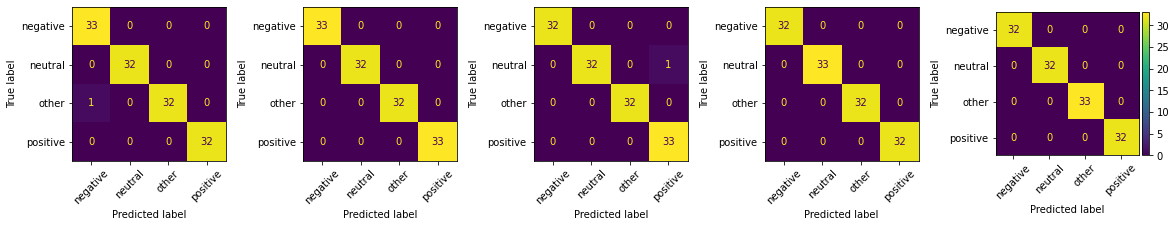

 
 Mean Test accuracy across folds for KKL366_220125_deconvolved: 99.58333333333333


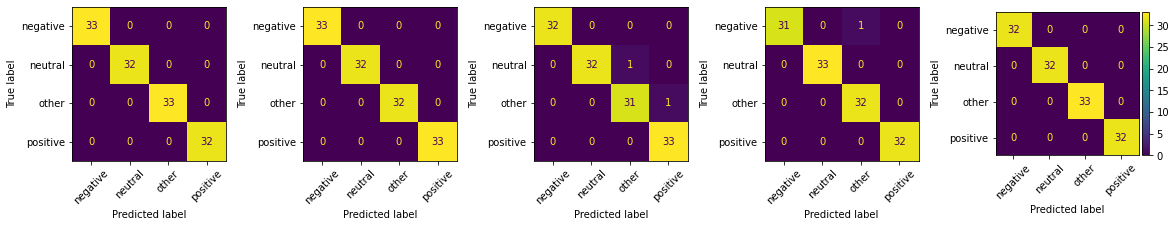

 
 Mean Test accuracy across folds for KKL366_220125_dff-denoised: 99.72222222222221


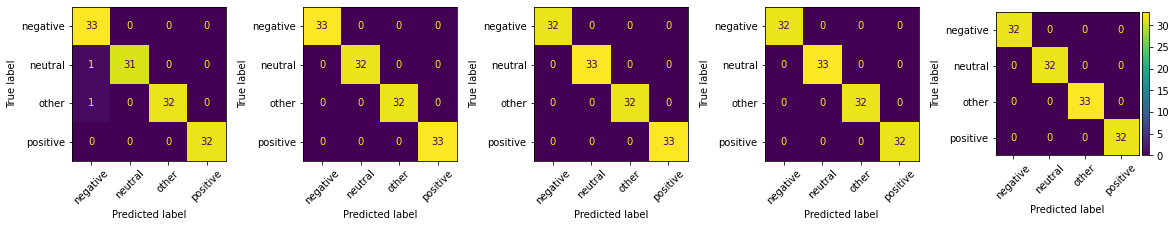

 
 Mean Test accuracy across folds for KKL366_220126_deconvolved: 99.86111111111111


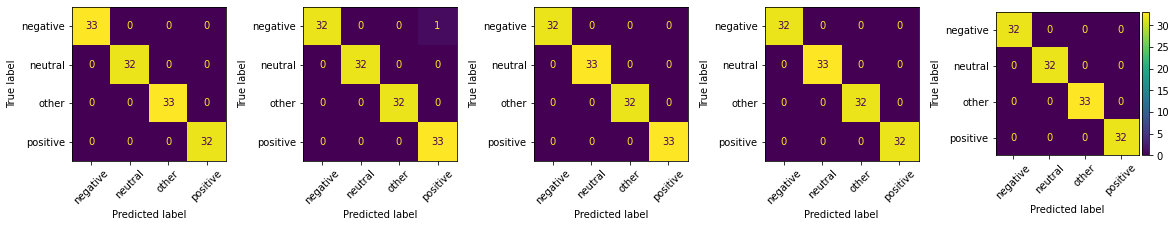

 
 Mean Test accuracy across folds for KKL366_220126_dff-denoised: 99.86111111111111


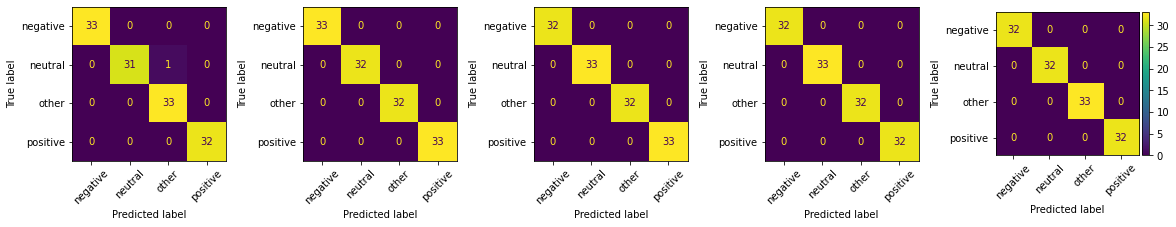

In [5]:
kfold = StratifiedKFold(n_splits= 5, random_state=42, shuffle=True)  

# load session
for fn in file_names:
    
    #define sub-plots for confusion matrix
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    
    #load data
    data = np.load(fn+'_data.npy')
    labels = np.load(fn+'_labels.npy')
#     print(data.shape, labels.shape, Counter(labels))

    # undersample data to have equal distribution of classes
    data_ds, labels_ds, label_classes = downsample(data, labels)
    data_ds, labels_ds = np.array(data_ds, dtype= 'float32'), np.array(labels_ds, dtype = 'float32')
    
    # define neural net dimensions and params
    n_in, n_h, n_out = np.shape(data_ds)[-1], 100, len(np.unique(labels_ds)) # input, hidden& output nodes
    epochs = 30

    # Define model
    model = model_def(n_in, n_h, n_out)
#     print(model)

    # Define the loss
    criterion = nn.CrossEntropyLoss()

    # Optimizers require the parameters to optimize and a learning rate
    optimizer = optim.SGD(model.parameters(), lr=0.003)

    # data splitting
    test_fold_acc =[]     
    for fold, (train_ids, test_ids) in enumerate(kfold.split(data_ds, labels_ds)):
#         print('For fold-'+str(fold+1)+':')
        #create dataloader
        batch = 16
        train_loader = DataLoader(TPDataset(data_ds, labels_ds, train_ids, test_ids), batch_size=batch, shuffle=True, drop_last=True, pin_memory=True)
        val_loader = DataLoader(TPDataset(data_ds, labels_ds, train_ids, test_ids, phase=1), batch_size=batch)
        test_loader = DataLoader(TPDataset(data_ds, labels_ds,train_ids, test_ids, phase=2), batch_size=batch)

        # train model
        foldername = '/home/priya/Desktop/CompSci/compsci-project-2/src/models/'+fn+'/'
        if not os.path.exists(foldername):
            os.makedirs(foldername)
        model, epoch = training(train_loader,val_loader, model, epochs, criterion, optimizer, foldername)

        # evaluate on test loader
        checkpoint = torch.load(os.path.join(foldername, 'epoch_'+str(epoch)+'.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        test_acc = 0
        outs, gts =[], []
        for data, labels in test_loader:
            output = model(data.float())
            #compute accuracy
            test_acc += (torch.argmax(output, axis=-1)==labels).sum().item()/labels.size(0)
            outs.append(torch.argmax(output, axis=-1))
            gts.append(labels)
        
        #compute confusion matrix 
        gts= [item for sublist in gts for item in sublist]
        outs= [item for sublist in outs for item in sublist]
        cm = confusion_matrix(gts, outs)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_classes)
        disp.plot(ax= axs[fold], xticks_rotation=45)
        disp.im_.colorbar.remove()
        
#         print(f"Test accuracy: {test_acc/len(test_loader)}" )
        test_fold_acc.append(test_acc/len(test_loader))

    print(f" \n Mean Test accuracy across folds for {fn}: {np.mean(test_fold_acc)*100}" )
    divider = make_axes_locatable(axs[fold])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(disp.im_, cax =cax)
    plt.show()